## Part 1: Database Design and ETL Pipeline

## Problem Statement

#### FlexiMart has three CSV files containing customer, product, and sales data with quality issues. You need to:
- Clean and load this data into a MySQL/PostgreSQL database
- Document the database schema
- Answer specific business questions


### Extract: Read all three CSV files
### Transform:
- Remove duplicate records
- Handle missing values (use appropriate strategy: drop, fill, or default)
- Standardize phone formats (e.g., +91-9876543210)
- Standardize category names (e.g., "electronics", "Electronics", "ELECTRONICS" → "Electronics")
- Convert date formats to YYYY-MM-DD
- Add surrogate keys (auto-incrementing IDs)

In [ ]:
# Import the necessary packages

import pandas as pd
import numpy as np
import phonenumbers
import os
import pathlib

current_path = pathlib.Path.cwd()
os.chdir(current_path /'data')

In [2]:
# read the raw data files function
def read_raw_data(file_name, sep = None):

    df = pd.read_csv(file_name)
    return df

In [3]:
data_quality_report = []
# Below is the general funcation to check and handle missing value in the columns of the dataframe
def find_treat_missing_val(df: pd.DataFrame):

    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    
    for col, cnt in df.isna().sum().items():
        if cnt > 0:
            missing_col =''.join(f"{col}: {cnt}")
            if col in numeric_cols:
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna('Unknown')
    
    dte_col = df.columns[df.columns.str.contains('date', case=False)]
    if len(dte_col) != 0:
        df[dte_col[0]] = pd.to_datetime(df[dte_col[0]], format='mixed', errors="coerce").dt.strftime("%Y-%m-%d")

    transform_df = df.drop_duplicates(keep='first')

    data_quality_report.append({
        'Record Count': len(df),
        'Duplicate Rows': int(df.duplicated().sum()),
        'Null Count': missing_col,
        'Insert Count': len(transform_df)
        })

    return transform_df, data_quality_report

## Inserting the data to the MYSQL database tables

In [ ]:
import mysql.connector
from dotenv import load_dotenv
import os

In [ ]:
def upload_data_db(df: pd.DataFrame, table_name):

    load_dotenv()
    conn_string = mysql.connector.Connect(
    host = os.getenv('MYSQL_HOST_URL'),
    user = os.getenv('MYSQL_USER'),
    password = os.getenv('MYSQL_PWD'),
    database = os.getenv('MYSQL_DB')
    )

    cursor = conn_string.cursor()

    cols_names = ",".join(df.columns)
    placeholder = ",".join(["%s"] * len(df.columns))
    sql = f"insert into {os.getenv('MYSQL_DB')}.{table_name} ({cols_names}) values ({placeholder})"

    cursor.executemany(sql, df.values.tolist())

    conn_string.commit()

    cursor.close()
    conn_string.close()    

### Customer Data

In [6]:
cust_df = read_raw_data('customers_raw.csv')
cust_df_clean, dq_report = find_treat_missing_val(cust_df)
cust_df_clean['phone'] = cust_df_clean['phone'].apply(lambda x: phonenumbers.format_number(phonenumbers.parse(x, region='IN'),phonenumbers.PhoneNumberFormat.E164))
cust_df_clean['customer_id'] = cust_df_clean['customer_id'].astype(str).str.replace(r'\D+', '', regex=True)
upload_data_db(cust_df_clean,'customers')
cust_df_clean.head()

/var/folders/7p/n2lb5v_14n78c1vydxw466400000gn/T/ipykernel_69250/19283353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_df_clean['phone'] = cust_df_clean['phone'].apply(lambda x: phonenumbers.format_number(phonenumbers.parse(x, region='IN'),phonenumbers.PhoneNumberFormat.E164))
/var/folders/7p/n2lb5v_14n78c1vydxw466400000gn/T/ipykernel_69250/19283353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_df_clean['customer_id'] = cust_df_clean['customer_id'].astype(str).str.replace(r'\D+', '', 

,customer_id,first_name,last_name,email,phone,city,registration_date
0,001,Rahul,Sharma,rahul.sharma@gmail.com,+919876543210,Bangalore,2023-01-15
1,002,Priya,Patel,priya.patel@yahoo.com,+919988776655,Mumbai,2023-02-20
2,003,Amit,Kumar,Unknown,+919765432109,Delhi,2023-03-10
3,004,Sneha,Reddy,sneha.reddy@gmail.com,+919123456789,Hyderabad,2023-04-15
4,005,Vikram,Singh,vikram.singh@outlook.com,+919988112233,Chennai,2023-05-22


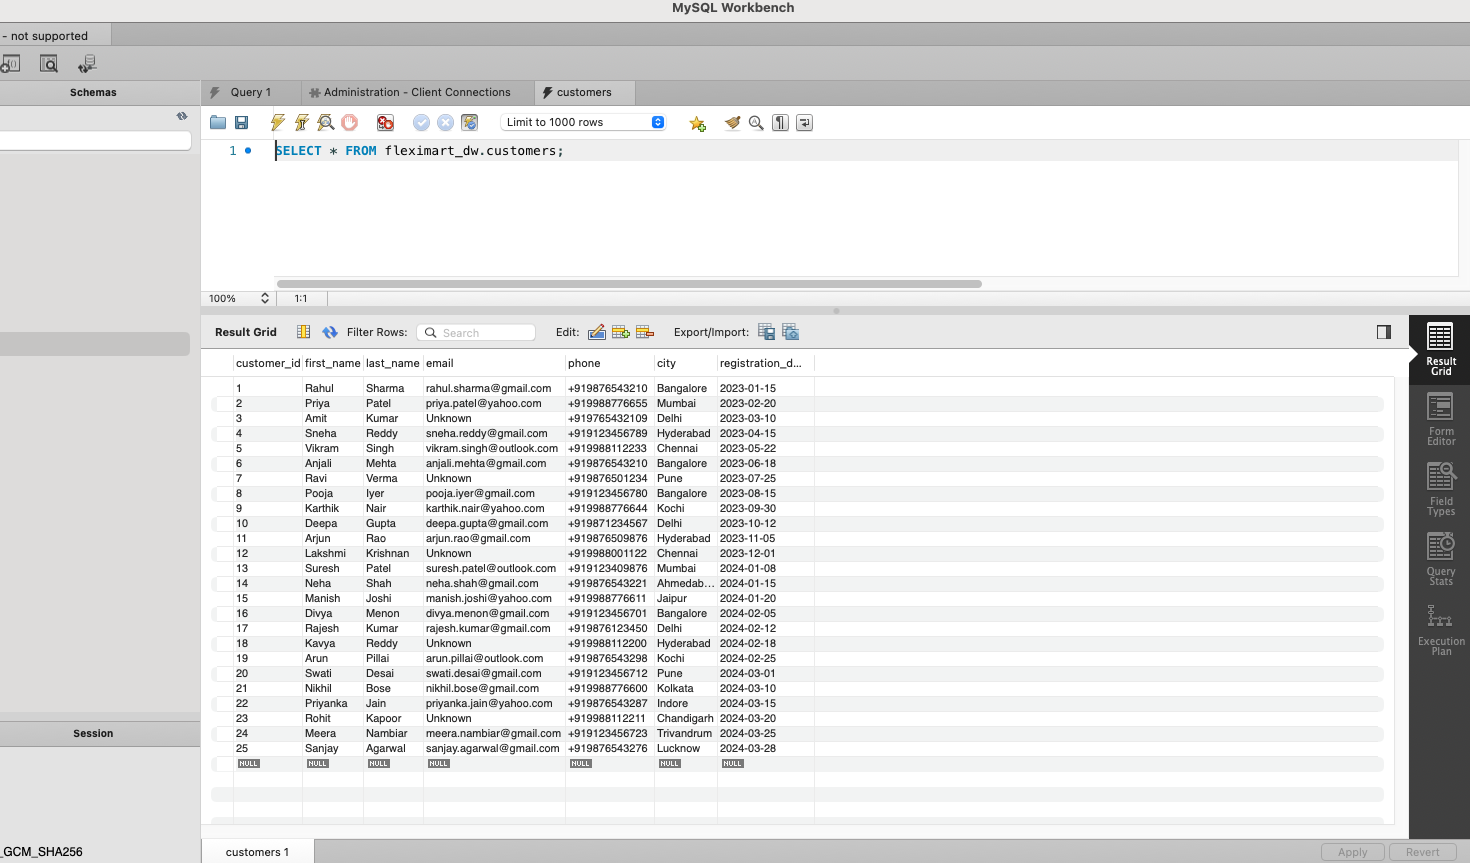

### Product Data

In [7]:
prod_df = read_raw_data('products_raw.csv')
prod_df_clean, dq_report = find_treat_missing_val(prod_df)
prod_df_clean['product_id'] = prod_df_clean['product_id'].astype(str).str.replace(r'\D+', '', regex=True)
prod_df_clean['category'] = prod_df_clean['category'].str.title()
upload_data_db(prod_df_clean,'products')
prod_df_clean.head()

,product_id,product_name,category,price,stock_quantity
0,001,Samsung Galaxy S21,Electronics,45999.0,150.0
1,002,Nike Running Shoes,Fashion,3499.0,80.0
2,003,Apple MacBook Pro,Electronics,2999.0,45.0
3,004,Levi's Jeans,Fashion,2999.0,120.0
4,005,Sony Headphones,Electronics,1999.0,200.0


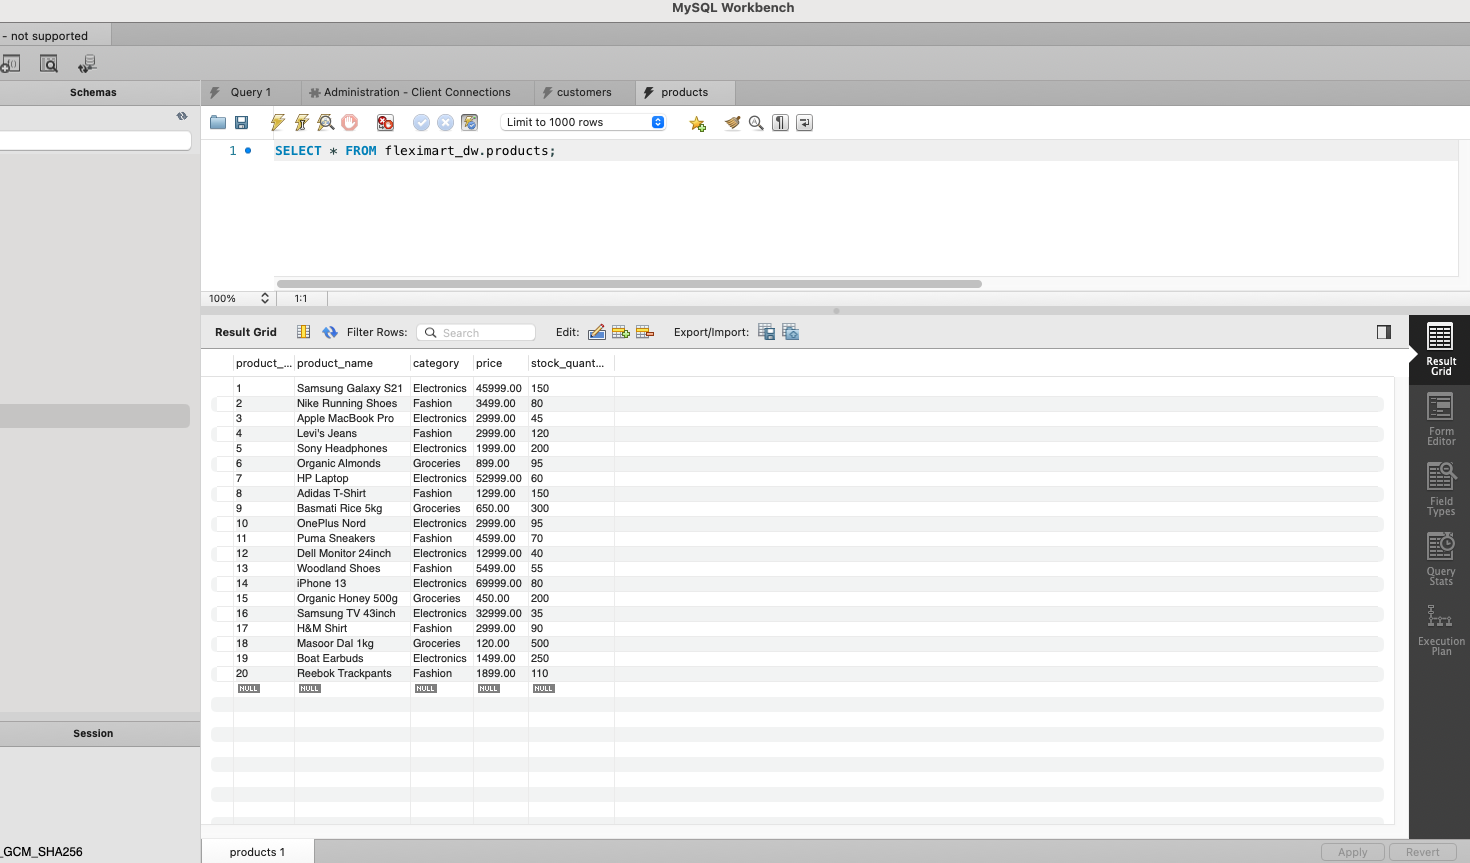

### Transcation Data

In [8]:
sales_df = read_raw_data('sales_raw.csv')
sales_df_clean, dq_report = find_treat_missing_val(sales_df)



sales_df_clean = sales_df_clean[~sales_df_clean.eq('Unknown').any(axis=1)]

sales_df_clean['total_amount'] = sales_df_clean['quantity'] * sales_df_clean['unit_price'] 
sales_df_clean[['transaction_id', 'customer_id','product_id']] = sales_df_clean[['transaction_id', 'customer_id','product_id']].astype(str).apply(lambda s:s.str.replace(r'\D+', '', regex=True))
sales_df_clean.rename(columns={'transaction_id': 'order_id','transaction_date':'order_date'}, inplace=True)

In [9]:
upload_data_db(sales_df_clean[['order_id','customer_id','order_date','total_amount','status']],'orders')
upload_data_db(sales_df_clean[['product_id','order_id','quantity','unit_price']],'order_items')
sales_df_clean.head()

,order_id,customer_id,product_id,quantity,unit_price,order_date,status,total_amount
0,001,001,001,1,45999.0,2024-01-15,Completed,45999.0
1,002,002,004,2,2999.0,2024-01-16,Completed,5998.0
2,003,003,007,1,52999.0,2024-01-15,Completed,52999.0
4,005,005,009,3,650.0,2024-01-20,Completed,1950.0
5,006,006,012,1,12999.0,2024-01-22,Completed,12999.0


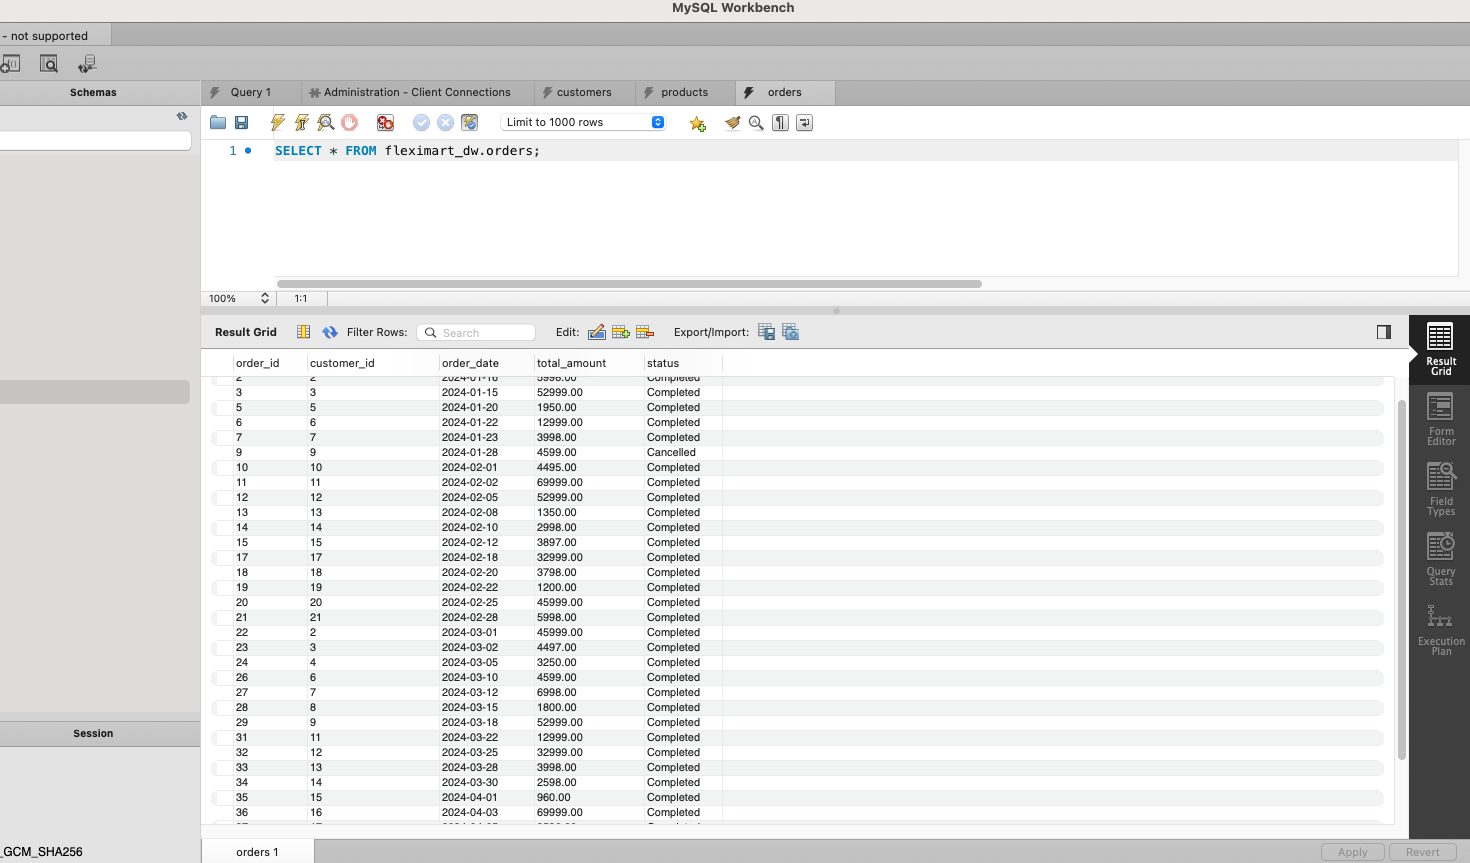

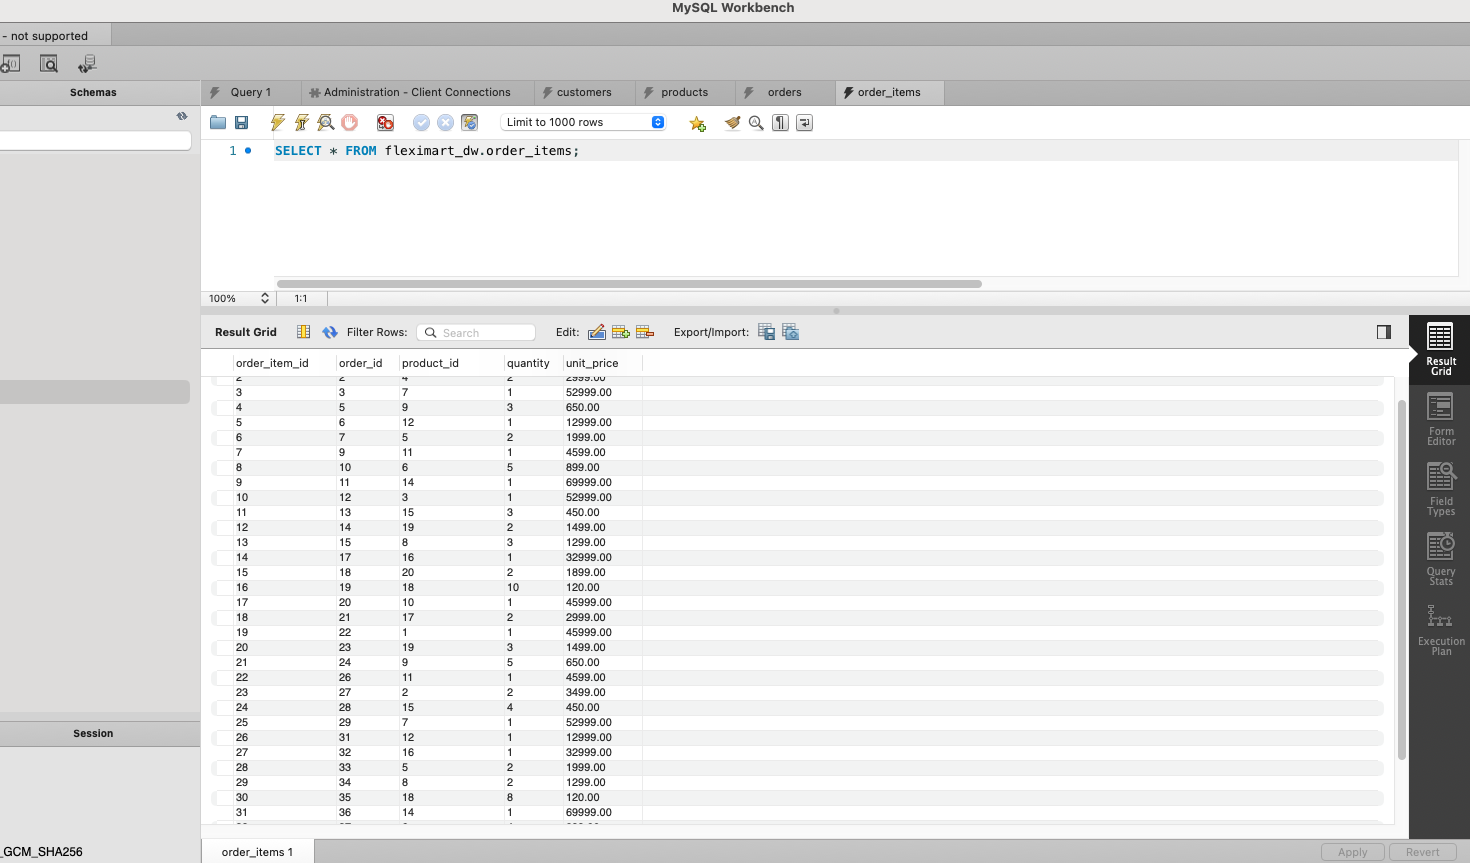

### Data Quality Report

In [10]:
pd.DataFrame(dq_report)

,Record Count,Duplicate Rows,Null Count,Insert Count
0,26,1,email: 5,25
1,20,0,stock_quantity: 1,20
2,41,1,product_id: 2,40
